Missing values before cleaning: 20
Class distribution:
 Class
0.0    19812
1.0       85
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:20:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Isolation Forest Results:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19812
         1.0       0.70      0.16      0.27        85

    accuracy                           1.00     19897
   macro avg       0.85      0.58      0.63     19897
weighted avg       1.00      1.00      0.99     19897

LOF Results:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19812
         1.0       0.00      0.00      0.00        85

    accuracy                           0.99     19897
   macro avg       0.50      0.50      0.50     19897
weighted avg       0.99      0.99      0.99     19897

Confusion Matrix:
 [[65  0]
 [ 1 19]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        65
         1.0       1.00      0.95      0.97        20

    accuracy                           0.99        85
   macro avg       0.99  

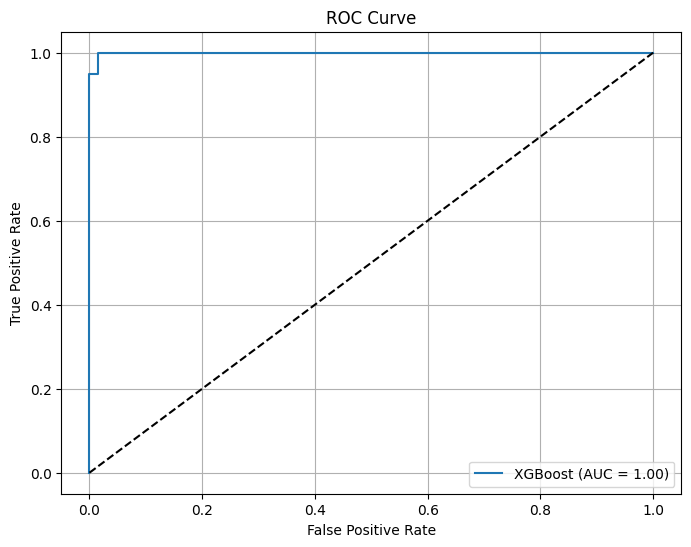

['xgb_fraud_model.pkl']

In [1]:
# fraud_detection.ipynb

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from xgboost import XGBClassifier
import joblib

# Load dataset
df = pd.read_csv('creditcard.csv')

# Check and handle missing values
print(f"Missing values before cleaning: {df.isnull().sum().sum()}")
df.dropna(inplace=True)

# Display class distribution
print("Class distribution:\n", df['Class'].value_counts())

# Scale 'Amount' and drop 'Time'
df['Amount'] = StandardScaler().fit_transform(df[['Amount']])
df.drop(['Time'], axis=1, inplace=True)

# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Apply anomaly detection
iso_forest = IsolationForest(n_estimators=100, contamination=0.001, random_state=42)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.001)

# Fit Isolation Forest
y_pred_iso = iso_forest.fit_predict(X)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)

# Fit LOF
y_pred_lof = lof.fit_predict(X)
y_pred_lof = np.where(y_pred_lof == -1, 1, 0)

# Evaluate anomaly detection
print("Isolation Forest Results:\n", classification_report(y, y_pred_iso))
print("LOF Results:\n", classification_report(y, y_pred_lof))

# Balance dataset using undersampling
fraud = df[df['Class'] == 1]
legit = df[df['Class'] == 0].sample(n=len(fraud) * 4, random_state=42)  # 1:4 ratio
balanced_df = pd.concat([fraud, legit]).sample(frac=1, random_state=42)

X_bal = balanced_df.drop('Class', axis=1)
y_bal = balanced_df['Class']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)

# Train XGBoost Classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Save the model
joblib.dump(model, 'xgb_fraud_model.pkl')